# Stable Diffusion -> SVG -> Scoring Metric + Simple SVG

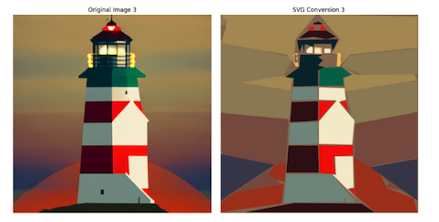

0. Using init svg as the svg in kawchar85/lb-0-508-simple-svg, teshu0/lb-0-669-single-aesthetic-svg-with-text and iiyamaiiyama/drawing-with-llms-lb-0-635
1. Use Stable Diffusion to generate images for prompts
2. Convert images to svg
3. Use competition metric to grade
4. Repeat steps 1-3 X times - and choose best scoring image

Depending on configuration - the notebook takes about ~10-20 seconds to generate, convert and score a single image.

At 20 inference steps for Stable Diffusion - this allows for 3-4x image candidates per prompt given time constraints.

**Now featuring LB score and runtime estimation!**

In [1]:
#| default_exp core

In [2]:
#| export

import kagglehub

import os
import io
import re
import random
import base64
from io import BytesIO

import time
from datetime import timedelta

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from IPython.display import SVG

from PIL import Image
import cv2

from diffusers import StableDiffusionPipeline
from transformers import AutoProcessor, AutoModel

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Competition Metric
* https://www.kaggle.com/code/metric/svg-image-fidelity
* Umodified except for model paths in AestheticEvaluator (for kagglehub packaging)

In [3]:
#| export

import io
from math import prod
from statistics import mean

from IPython.display import SVG

import cairosvg
import clip
import kagglehub
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from transformers import (
    AutoProcessor,
    BitsAndBytesConfig,
    PaliGemmaForConditionalGeneration,
)

svg_constraints = kagglehub.package_import('metric/svg-constraints')

class ParticipantVisibleError(Exception):
    pass


def score(
    solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str
) -> float:
    """Calculates a fidelity score by comparing generated SVG images to target text descriptions.

    Parameters
    ----------
    solution : pd.DataFrame
        A DataFrame containing target text descriptions. Must have a column named 'description'.
    submission : pd.DataFrame
        A DataFrame containing generated SVG strings. Must have a column named 'svg'.
    row_id_column_name : str
        The name of the column containing row identifiers. This column is removed before scoring.

    Returns
    -------
    float
        The mean fidelity score (a value between 0 and 1) representing the average similarity between the generated SVGs and their descriptions.
        A higher score indicates better fidelity.

    Raises
    ------
    ParticipantVisibleError
        If the 'svg' column in the submission DataFrame is not of string type or if validation of the SVG fails.

    Examples
    --------
    >>> import pandas as pd
    >>> solution = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'description': ['red ball', 'swimming pool']
    ... })
    >>> submission = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'svg': ['<svg viewBox="0 0 100 100"><circle cx="50" cy="50" r="40" fill="red"/></svg>',
    ...         '<svg viewBox="0 0 100 100"><rect x="10" y="10" width="80" height="80" fill="blue"/></svg>']
    ... })
    >>> score(solution, submission, 'id')
    0...
    """
    # Validate
    del solution[row_id_column_name], submission[row_id_column_name]
    if not pd.api.types.is_string_dtype(submission.loc[:, 'svg']):
        raise ParticipantVisibleError('svg must be a string.')
    # check that SVG code meets defined constraints
    constraints = svg_constraints.SVGConstraints()
    try:
        for svg in submission.loc[:, 'svg']:
            constraints.validate_svg(svg)
    except:
        raise ParticipantVisibleError('SVG code violates constraints.')

    # Score
    vqa_evaluator = VQAEvaluator()
    aesthetic_evaluator = AestheticEvaluator()

    results = []
    try:
        for svg, description in zip(
            submission.loc[:, 'svg'], solution.loc[:, 'description'], strict=True
        ):
            image = svg_to_png(svg)
            vqa_score = vqa_evaluator.score(image, 'SVG illustration of ' + description)
            aesthetic_score = aesthetic_evaluator.score(image)
            instance_score = harmonic_mean(vqa_score, aesthetic_score, beta=2.0)
            results.append(instance_score)

    except:
        raise ParticipantVisibleError('SVG failed to score.')

    fidelity = mean(results)
    return float(fidelity)


class VQAEvaluator:
    """Evaluates images based on their similarity to a given text description."""

    def __init__(self):
        self.quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.float16,
        )
        self.model_path = kagglehub.model_download(
            'google/paligemma-2/transformers/paligemma2-10b-mix-448'
        )
        self.processor = AutoProcessor.from_pretrained(self.model_path)
        self.model = PaliGemmaForConditionalGeneration.from_pretrained(
            self.model_path,
            low_cpu_mem_usage=True,
            quantization_config=self.quantization_config,
        )
        self.questions = {
            'fidelity': 'Does <image> portray "{}" without any lettering? Answer yes or no.',
            'text': '<image> Text present: yes or no?',
        }

    def score(self, image: Image.Image, description: str) -> float:
        """Evaluates the fidelity of an image to a target description using VQA yes/no probabilities.

        Parameters
        ----------
        image : PIL.Image.Image
            The image to evaluate.
        description : str
            The text description that the image should represent.

        Returns
        -------
        float
            The score (a value between 0 and 1) representing the match between the image and its description.
        """
        p_fidelity = self.get_yes_probability(image, self.questions['fidelity'].format(description))
        p_text = self.get_yes_probability(image, self.questions['text'])
        return p_fidelity * (1 - p_text)

    def mask_yes_no(self, logits):
        """Masks logits for 'yes' or 'no'."""
        yes_token_id = self.processor.tokenizer.convert_tokens_to_ids('yes')
        no_token_id = self.processor.tokenizer.convert_tokens_to_ids('no')
        yes_with_space_token_id = self.processor.tokenizer.convert_tokens_to_ids(' yes')
        no_with_space_token_id = self.processor.tokenizer.convert_tokens_to_ids(' no')

        mask = torch.full_like(logits, float('-inf'))
        mask[:, yes_token_id] = logits[:, yes_token_id]
        mask[:, no_token_id] = logits[:, no_token_id]
        mask[:, yes_with_space_token_id] = logits[:, yes_with_space_token_id]
        mask[:, no_with_space_token_id] = logits[:, no_with_space_token_id]
        return mask

    def get_yes_probability(self, image, prompt) -> float:
        inputs = self.processor(images=image, text=prompt, return_tensors='pt').to(
            'cuda:0'
        )

        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits[:, -1, :]  # Logits for the last (predicted) token
            masked_logits = self.mask_yes_no(logits)
            probabilities = torch.softmax(masked_logits, dim=-1)

        yes_token_id = self.processor.tokenizer.convert_tokens_to_ids('yes')
        no_token_id = self.processor.tokenizer.convert_tokens_to_ids('no')
        yes_with_space_token_id = self.processor.tokenizer.convert_tokens_to_ids(' yes')
        no_with_space_token_id = self.processor.tokenizer.convert_tokens_to_ids(' no')

        prob_yes = probabilities[0, yes_token_id].item()
        prob_no = probabilities[0, no_token_id].item()
        prob_yes_space = probabilities[0, yes_with_space_token_id].item()
        prob_no_space = probabilities[0, no_with_space_token_id].item()

        total_yes_prob = prob_yes + prob_yes_space
        total_no_prob = prob_no + prob_no_space

        total_prob = total_yes_prob + total_no_prob
        renormalized_yes_prob = total_yes_prob / total_prob

        return renormalized_yes_prob


class AestheticPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.layers(x)

class AestheticEvaluator:
    def __init__(self):

# -----------------modified paths for packaging!!!!-----------------
        self.model_path = kagglehub.notebook_output_download(
            'metric/sac-logos-ava1-l14-linearmse'
        ) + '/sac+logos+ava1-l14-linearMSE.pth'

        self.clip_model_path = kagglehub.notebook_output_download(
            'metric/openai-clip-vit-large-patch14'
        ) + '/ViT-L-14.pt'

        self.predictor, self.clip_model, self.preprocessor = self.load()

    def load(self):
        """Loads the aesthetic predictor model and CLIP model."""
        state_dict = torch.load(self.model_path, weights_only=True, map_location='cuda:1')

        # CLIP embedding dim is 768 for CLIP ViT L 14
        predictor = AestheticPredictor(768)
        predictor.load_state_dict(state_dict)
        predictor.to('cuda:1')
        predictor.eval()
        clip_model, preprocessor = clip.load(self.clip_model_path, device='cuda:1')

        return predictor, clip_model, preprocessor


    def score(self, image: Image.Image) -> float:
        """Predicts the CLIP aesthetic score of an image."""
        image = self.preprocessor(image).unsqueeze(0).to('cuda:1')

        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            # l2 normalize
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.cpu().detach().numpy()

        score = self.predictor(torch.from_numpy(image_features).to('cuda:1').float())

        return score.item() / 10.0  # scale to [0, 1]


def harmonic_mean(a: float, b: float, beta: float = 1.0) -> float:
    """
    Calculate the harmonic mean of two values, weighted using a beta parameter.

    Args:
        a: First value (e.g., precision)
        b: Second value (e.g., recall)
        beta: Weighting parameter

    Returns:
        Weighted harmonic mean
    """
    # Handle zero values to prevent division by zero
    if a <= 0 or b <= 0:
        return 0.0
    return (1 + beta**2) * (a * b) / (beta**2 * a + b)


def svg_to_png(svg_code: str, size: tuple = (384, 384)) -> Image.Image:
    """
    Converts an SVG string to a PNG image using CairoSVG.

    If the SVG does not define a `viewBox`, it will add one using the provided size.

    Parameters
    ----------
    svg_code : str
        The SVG string to convert.
    size : tuple[int, int], default=(384, 384)
        The desired size of the output PNG image (width, height).

    Returns
    -------
    PIL.Image.Image
        The generated PNG image.
    """
    # Ensure SVG has proper size attributes
    if 'viewBox' not in svg_code:
        svg_code = svg_code.replace('<svg', f'<svg viewBox="0 0 {size[0]} {size[1]}"')

    # Convert SVG to PNG
    png_data = cairosvg.svg2png(bytestring=svg_code.encode('utf-8'))
    return Image.open(io.BytesIO(png_data)).convert('RGB').resize(size)

# Load Stable Diffusion

In [4]:
#| export

# Ensure GPU is being used and optimize for speed
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler


# Load with optimized scheduler and half precision
stable_diffusion_path = kagglehub.model_download("stabilityai/stable-diffusion-v2/pytorch/1/1")

scheduler = DDIMScheduler.from_pretrained(stable_diffusion_path, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    stable_diffusion_path,
    scheduler=scheduler,
    torch_dtype=torch.float16,  # Use half precision
    safety_checker=None         # Disable safety checker for speed
)

# Move to GPU and apply optimizations
pipe.to(device)

Using device: cuda:1


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "/kaggle/input/stable-diffusion-v2/pytorch/1/1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# Competition Metric Helpers

In [5]:
#| export

global_vqa_evaluator = None
global_aesthetic_evaluator = None

def initialize_evaluators():
    """Initialize the evaluators once and store them in global variables"""
    global global_vqa_evaluator, global_aesthetic_evaluator
    
    if global_vqa_evaluator is None:
        print("Initializing VQA Evaluator...")
        global_vqa_evaluator = VQAEvaluator()
    
    if global_aesthetic_evaluator is None:
        print("Initializing Aesthetic Evaluator...")
        global_aesthetic_evaluator = AestheticEvaluator()
    
    return global_vqa_evaluator, global_aesthetic_evaluator


def evaluate_with_competition_metric(svg, prompt):

    vqa_evaluator, aesthetic_evaluator = initialize_evaluators()

    image = svg_to_png(svg)
    # Calculate scores
    vqa_score = vqa_evaluator.score(image, 'SVG illustration of ' + prompt)
    aesthetic_score = aesthetic_evaluator.score(image)
    combined_score = harmonic_mean(vqa_score, aesthetic_score, beta=2.0)
    
    return {
        'vqa_score': vqa_score,
        'aesthetic_score': aesthetic_score,
        'combined_score': combined_score
    }

# Image -> SVG
* Did a bunch of work here trying to get good results..

In [6]:
#| export

def compress_hex_color(hex_color):
    """Convert hex color to shortest possible representation"""
    r, g, b = int(hex_color[1:3], 16), int(hex_color[3:5], 16), int(hex_color[5:7], 16)
    if r % 17 == 0 and g % 17 == 0 and b % 17 == 0:
        return f'#{r//17:x}{g//17:x}{b//17:x}'
    return hex_color

def extract_features_by_scale(img_np, num_colors=12):
    """
    Extract image features hierarchically by scale
    
    Args:
        img_np (np.ndarray): Input image
        num_colors (int): Number of colors to quantize
    
    Returns:
        list: Hierarchical features sorted by importance
    """
    # Convert to RGB if needed
    if len(img_np.shape) == 3 and img_np.shape[2] > 1:
        img_rgb = img_np
    else:
        img_rgb = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
    
    # Convert to grayscale for processing
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    
    # Perform color quantization
    pixels = img_rgb.reshape(-1, 3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, num_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Quantized image
    palette = centers.astype(np.uint8)
    quantized = palette[labels.flatten()].reshape(img_rgb.shape)
    
    # Hierarchical feature extraction
    hierarchical_features = []
    
    # Sort colors by frequency
    unique_labels, counts = np.unique(labels, return_counts=True)
    sorted_indices = np.argsort(-counts)
    sorted_colors = [palette[i] for i in sorted_indices]
    
    # Center point for importance calculations
    center_x, center_y = width/2, height/2
    
    for color in sorted_colors:
        # Create color mask
        color_mask = cv2.inRange(quantized, color, color)
        
        # Find contours
        contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Sort contours by area (largest first)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        
        # Convert RGB to compressed hex
        hex_color = compress_hex_color(f'#{color[0]:02x}{color[1]:02x}{color[2]:02x}')
        
        color_features = []
        for contour in contours:
            # Skip tiny contours
            area = cv2.contourArea(contour)
            if area < 20:
                continue
            
            # Calculate contour center
            m = cv2.moments(contour)
            if m["m00"] == 0:
                continue
            
            cx = int(m["m10"] / m["m00"])
            cy = int(m["m01"] / m["m00"])
            
            # Distance from image center (normalized)
            dist_from_center = np.sqrt(((cx - center_x) / width)**2 + ((cy - center_y) / height)**2)
            
            # Simplify contour
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            # Generate points string
            points = " ".join([f"{pt[0][0]:.1f},{pt[0][1]:.1f}" for pt in approx])
            
            # Calculate importance (area, proximity to center, complexity)
            importance = (
                area * 
                (1 - dist_from_center) * 
                (1 / (len(approx) + 1))
            )
            
            color_features.append({
                'points': points,
                'color': hex_color,
                'area': area,
                'importance': importance
            })
        
        # Sort features by importance within this color
        color_features.sort(key=lambda x: x['importance'], reverse=True)
        hierarchical_features.extend(color_features)
    
    # Final sorting by overall importance
    hierarchical_features.sort(key=lambda x: x['importance'], reverse=True)
    
    return hierarchical_features

def bitmap_to_svg_layered(image, max_size_bytes=10000, resize=True, target_size=(256, 256)):
    """
    Convert bitmap to SVG using layered feature extraction
    
    Args:
        image: Input image (PIL.Image)
        max_size_bytes (int): Maximum SVG size
        resize (bool): Whether to resize the image before processing
        target_size (tuple): Target size for resizing (width, height)
    
    Returns:
        str: SVG representation
    """
    # Resize the image if requested
    if resize:
        original_size = image.size
        image = image.resize(target_size, Image.LANCZOS)
    else:
        original_size = image.size
    
    # Convert to numpy array
    img_np = np.array(image)
    
    # Get image dimensions
    height, width = img_np.shape[:2]
    
    # Calculate average background color
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        avg_bg_color = np.mean(img_np, axis=(0,1)).astype(int)
        bg_hex_color = compress_hex_color(f'#{avg_bg_color[0]:02x}{avg_bg_color[1]:02x}{avg_bg_color[2]:02x}')
    else:
        bg_hex_color = '#fff'
    
    # Start building SVG
    # Use original dimensions in viewBox for proper scaling when displayed
    orig_width, orig_height = original_size
    svg = f'<svg xmlns="http://www.w3.org/2000/svg" width="{orig_width}" height="{orig_height}" viewBox="0 0 {width} {height}">\n'
    svg += f'<rect width="{width}" height="{height}" fill="{bg_hex_color}"/>\n'
    
    # Extract hierarchical features
    features = extract_features_by_scale(img_np)
    
    # Add features layer by layer
    for feature in features:
        # Try adding the feature
        temp_svg = svg + f'<polygon points="{feature["points"]}" fill="{feature["color"]}" />\n</svg>'
        
        # Check if adding this feature exceeds size limit
        if len(temp_svg.encode('utf-8')) > max_size_bytes:
            break
        
        # Add the feature
        svg += f'<polygon points="{feature["points"]}" fill="{feature["color"]}" />\n'
    
    # Close SVG
    svg += '</svg>'
    
    # Final size check
    if len(svg.encode('utf-8')) > max_size_bytes:
        return f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 {width} {height}"><rect width="{width}" height="{height}" fill="{bg_hex_color}"/></svg>'
    
    return svg

# Bitmap Generation
* Inference steps (more for better quality / slower)
* Guidance scale (how tightly to follow prompts)

In [7]:
#| export

def generate_bitmap(prompt, negative_prompt="", num_inference_steps=20, guidance_scale=15):
        
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps, 
        guidance_scale=guidance_scale
    ).images[0]
    
    return image

#  Generate Image, Convert to SVG, and Score
* Repeat as needed - pick the best scoring SVG

In [8]:
# | export
DEFAULT_SVGS = [
    """<svg width="1000" height="1000" viewBox="0 0 1000 1000" xmlns="http://www.w3.org/2000/svg"><defs><radialGradient id="a" cx="60%" cy="40%" r="85%"><stop offset="0%" stop-color="#0f172a"/><stop offset="100%" stop-color="#1e3b8a"/></radialGradient><linearGradient id="c" x1="0" y1="0" x2="1" y2="1"><stop offset="0%" stop-color="#4ade80"/><stop offset="50%" stop-color="#2dd4bf"/><stop offset="100%" stop-color="#5eead4"/></linearGradient><pattern id="b" width="100" height="100" patternUnits="userSpaceOnUse"><path d="M100 0H0v100" stroke="#f8fafc" stroke-width="2" opacity=".1"/></pattern></defs><path fill="url(#a)" d="M0 0h1000v1000H0z"/><path fill="url(#b)" opacity=".15" d="M0 0h1000v1000H0z"/><g transform="translate(500 500)"><path d="m0-200 57 7L193-57l7 57-7 57L57 193l-57 7-57-7-136-136-7-57 7-57 136-136Z" fill="none" stroke="url(#c)" stroke-width="15" stroke-linejoin="round" opacity=".97"/><g transform="scale(.6)"><circle r="140" fill="#4ade80" opacity=".95"/><path d="m-100-100 200 200m0-200-200 200" stroke="#0f172a" stroke-width="25" stroke-linecap="round"/><path d="M0-140v-60m0 340v60M-140 0h-60m340 0h60" stroke="#2dd4bf" stroke-width="8"/></g><circle cx="300" r="15" fill="#5eead4"/><circle cx="-300" r="15" fill="#5eead4"/></g><g opacity=".3"><circle cx="250" cy="250" r="30" fill="url(#c)"/><circle cx="750" cy="750" r="40" fill="#2dd4bf"/><rect x="600" y="200" width="60" height="60" rx="15" fill="#5eead4"/><path d="m200 600 100 100 100-100Z" fill="#4ade80"/></g><path d="M500 100v800M100 500h800" stroke="#f8fafc" stroke-width="4" opacity=".15"/></svg>""",
    """<svg xmlns="http://www.w3.org/2000/svg" width="384" height="384"><rect width="100%" height="100%"/><path d="M80 82h224v224H80z"/><g fill="none" stroke-linecap="round" stroke-linejoin="round"><path stroke="#FF4700" stroke-width="12" d="M150 199q131-7 45-73"/><path stroke="#000010" stroke-opacity=".1" stroke-width="8" d="M270 220q-165-138-99 43"/><path stroke="#FF5E00" stroke-width="4" d="M88 83q-4 70 150 54"/><path stroke="#000" stroke-opacity=".6" stroke-width="8" d="M239 232q-80-23 5-136"/><path stroke="#0000C7" stroke-opacity=".7" stroke-width="16" d="M202 286q76-84 12-25"/><path d="M223 228q-143-98 56-43"/><path stroke="#00002A" stroke-opacity=".6" stroke-width="16" d="M121 268q129 18 124-8"/><path stroke="#8AACFF" stroke-opacity=".5" stroke-width="4" d="M304 85q-13 94-138 12"/><path stroke="#04F" stroke-width="12" d="M242 95q-84 96-47 9"/><path stroke="#13FFFF" stroke-width="6" d="M94 166q41-51 72 57"/><path d="M150 134q75 70-5 126"/><path stroke="#FF6300" stroke-width="14" d="M160 103q24-17 80 9"/><path stroke="#446AFF" stroke-width="2" d="M129 232q91 50 156 74"/><path stroke="#00f" stroke-opacity=".3" stroke-width="2" d="M120 131q-21-43 67 50"/><path stroke="#fff" stroke-width="12" d="M124 135q26-48-19 29"/><path stroke="#FDA1F6" stroke-opacity=".5" stroke-width="10" d="M280 175q23 27-200 100"/><path stroke="#C77145" stroke-opacity=".7" stroke-width="16" d="M133 256q132 0 120-87"/><path stroke="#FF0400" stroke-width="12" d="M123 175q-8-33 18 62"/><path d="M135 111q119 59 139 55"/><path stroke="#FF7C00" stroke-width="10" d="M166 250q-30-95 20-168"/><path stroke="#FFE415" stroke-opacity=".8" stroke-width="16" d="M169 108q11 77 27 93"/><path stroke="#470C00" stroke-opacity=".6" stroke-width="16" d="M234 99q-131 166 2 141"/><path stroke="#040000" stroke-opacity=".4" stroke-width="4" d="M92 172q50 11 87 78"/><path d="M143 112q-9 116 93 150"/><path stroke="#fff" stroke-width="12" d="M195 82q-40 0-92 88"/><path d="M169 103q-84 152 42 151"/><path stroke="#fff" stroke-width="14" d="M252 193q18 43-165 38"/><path stroke="#0A61FF" stroke-opacity=".6" stroke-width="6" d="M117 176q131-82 132 0"/><path stroke="#09A7E4" stroke-width="14" d="M141 223q123-78 65 29"/><path stroke="#34009E" stroke-opacity=".3" stroke-width="16" d="M232 237q43 37 44-72"/><path d="M215 280q88-20 63-88"/><path stroke="#FF4000" stroke-width="10" d="M246 223q-140-71-89 50"/><path stroke="#FFB000" stroke-width="6" d="M187 82q-66 51-103 10"/><path d="M131 168q37 50-27-66"/><path stroke="#FF614F" stroke-width="2" d="M282 248q-158 55 22-22"/><path stroke="#FF9D7A" stroke-width="16" d="M176 153q-44-31-74 109"/><path stroke="#57001C" stroke-opacity=".2" stroke-width="16" d="M206 151q66 57-126 131"/><path stroke="#F50048" stroke-opacity=".4" stroke-width="16" d="M265 199q-133-75-121-7"/><path stroke="#AE1600" stroke-opacity=".7" stroke-width="12" d="M291 256Q84 155 91 165"/><path stroke="#34FFFF" stroke-width="12" d="M95 162q36-67 112-12"/><path stroke="#7B9D6C" stroke-opacity=".6" stroke-width="2" d="M271 158q-62 18-177 111"/><path stroke="red" stroke-width="6" d="M211 210q-101-13-128-51"/><path stroke="#005478" stroke-opacity=".9" stroke-width="4" d="M118 118Q89 241 232 242"/><path d="M147 230q-58-98-51 25"/><path stroke="#0074FF" stroke-opacity=".9" stroke-width="4" d="M154 172q60 68-35 47"/><path stroke="#000574" stroke-opacity=".4" stroke-width="16" d="M101 277q182-67 163-142"/><path stroke="#00005E" stroke-opacity=".1" stroke-width="14" d="M275 168q-87 27-48-66"/><path stroke="#00B6AB" stroke-width="2" d="M209 84q-115 20 72 83"/><path stroke="#00718B" stroke-opacity=".9" stroke-width="14" d="M111 105q93 32-19 70"/><path d="M188 265q-90 16-69 35"/><path stroke="#FDFF00" stroke-width="2" d="M205 214q-82-20-31-132"/><path d="M267 127q33 82 14 135"/><path stroke="#FFFFB7" stroke-width="8" d="M98 255q153-123 52-149"/><path stroke="#BD003F" stroke-opacity=".3" stroke-width="16" d="M270 188Q202 84 80 262"/><path stroke="#EC8500" stroke-opacity=".8" stroke-width="16" d="M254 121q-131-35-20 46"/><path stroke="#950200" stroke-opacity=".4" stroke-width="10" d="M203 162q87-38 7 103"/><path stroke="#FFD670" stroke-opacity=".7" stroke-width="12" d="M249 214q-169-48-131 42"/><path d="M210 226q29-131-75-133"/><path stroke="#FFC559" stroke-opacity=".7" stroke-width="6" d="M201 83q76 56 96 38"/><path d="M150 117q70 160 48 131"/><path stroke="#000020" stroke-width="4" d="M264 221q37-65-13-38"/><path stroke="#595987" stroke-opacity=".6" stroke-width="12" d="M248 246q-38-90 13-81"/><path stroke="#0344A0" stroke-opacity=".6" stroke-width="16" d="M80 265q204-51 1-26"/><path stroke="#F60" stroke-width="10" d="M298 239q-168-31-160-12"/><path stroke="#A47686" stroke-opacity=".5" stroke-width="14" d="M273 152q-92-70-136 32"/><path stroke="#FFAF67" stroke-width="16" d="M166 129q1-46-47 79"/><path stroke="#00000A" stroke-opacity=".5" stroke-width="6" d="M304 162q-35-36-89-14"/><path stroke="#1E167F" stroke-width="10" d="M302 242q-86-26-49-56"/><path stroke="#620114" stroke-opacity=".9" stroke-width="2" d="M248 257q-14-145-56-160"/><path stroke="#C6000D" stroke-opacity=".3" stroke-width="2" d="M217 82q-39 116-128 85"/><path stroke="#000" stroke-opacity=".7" stroke-width="4" d="M109 306q-28-3-20-224"/><path stroke="#ff0" stroke-opacity=".2" stroke-width="6" d="M165 96q6 141 57 117"/><path stroke="#00636C" stroke-width="14" d="M118 165q67 89 16 77"/><path stroke="#F03A00" stroke-opacity=".5" stroke-width="6" d="M253 162q-136-61 51-27"/><path stroke="#275E99" stroke-opacity=".6" stroke-width="16" d="M227 306q-6-72-111-145"/><path d="M250 167q-22-15-169 61"/><path stroke="#01F0C3" stroke-opacity=".6" stroke-width="14" d="M217 199q8 1-118 53"/><path stroke="#FDFF80" stroke-opacity=".3" stroke-width="14" d="M147 134q108-52 65-33"/><path stroke="#5E448B" stroke-opacity=".4" stroke-width="16" d="M198 306q-57-143-60-129"/><path d="M112 135q148 110 13 96"/><path stroke="#798CBA" stroke-opacity=".6" stroke-width="4" d="M245 231q-115 2 34-72"/><path stroke="#FFFFD4" stroke-width="4" d="M92 158q195 102 157 90"/><path stroke="#0093FF" stroke-opacity=".8" stroke-width="12" d="M131 228q-38-33 77-4"/><path stroke="#F25A27" stroke-opacity=".3" stroke-width="14" d="M204 211q72-115-83 0"/><path stroke="#1A4BE6" stroke-opacity=".5" stroke-width="14" d="M227 306q-122-190 77-12"/><path stroke="#04737C" stroke-opacity=".5" stroke-width="16" d="M227 123q-56 42-123 41"/><path stroke="#FF9F10" stroke-opacity=".9" stroke-width="4" d="M135 106q-48 69 144 133"/><path stroke="#8C8086" stroke-opacity=".4" stroke-width="8" d="M296 116q-182 47-102 5"/><path stroke="#00F6FF" stroke-width="2" d="M243 159q-63 24 61-22"/><path stroke="#F97658" stroke-opacity=".4" stroke-width="12" d="M209 120q-91 68-110 134"/><path stroke="#FF3600" stroke-width="12" d="M174 206q20-109 73-30"/><path stroke="#8A0000" stroke-width="4" d="M106 92q46 98 116 122"/><path stroke="#817E60" stroke-opacity=".9" stroke-width="12" d="M188 158q34 82-67-20"/><path stroke="#000040" stroke-width="16" d="M115 274q189-68 35-118"/><path stroke="#976000" stroke-opacity=".4" stroke-width="12" d="M277 169q-38-26-182 73"/><path stroke="#59693F" stroke-opacity=".6" stroke-width="10" d="M158 158q129 98-25 30"/></g><rect width="100%" height="80"/><rect width="100%" height="80" y="304"/><rect width="80" height="100%"/><rect width="80" height="100%" x="304"/><g stroke="#616161"><path d="m140 320.5 4 7m0 0v5.5m0-5.5 4-7"/><path id="a" d="M172.6 324v3.5m0 0v9.5m0-9.5c8-13 7.4 14.5 0 1.5"/><use x="21" y="36" href="#a"/><path id="b" d="M164.774 324.408s-9.472-.045-3 4c8 5-3 4-3 4"/><use x="60" y="36" href="#b"/><use x="71" href="#b"/><use x="77" y="18" href="#b"/><path id="c" d="M149.5 364.5c0 2.5-1.5 4-3 4s-3-1.5-3-4 1.5-4 3-4 3 1.5 3 4Z"/><use x="20" y="-18" href="#c"/><use x="39" y="-36" href="#c"/><path id="d" d="M150 328c1-8 7-2 6 0zm0 0c0 6 6 4 6 4"/><use x="78" y="36" href="#d"/><use x="60" y="36" href="#d"/><use x="14" y="36" href="#d"/><use x="49" y="18" href="#d"/><use x="72" y="18" href="#d"/><path id="e" d="M192 323v3m0 7v-7m0 0 4-3"/><use x="11" y="36" href="#e"/><use x="39" y="18" href="#e"/><use x="14" href="#e"/><path id="f" d="M146 343h2m4 0h-4m0 0v-3m0 3v7.5l3.5.5"/><use x="52" y="-18" href="#f"/><use x="38" href="#f"/><use x="10" y="18" href="#f"/><use x="101" y="18" href="#f"/><use x="36" y="18" href="#f"/><use x="61" href="#f"/><use x="68" href="#f"/><path d="M218 333v-3m-5-6c6-2 5 4 5 4m0 0s-6-2-6 2c1 5 6 0 6 0m0-2v2m3-6 4 9m0 0 3-9m-3 9-4 4m-92.5 4.5 2.5 8.5 3-7.5 3.5 7.5 2.5-8.5m56-3.5v14m-42.5-1v-7m0-7v7m0 0s7-7.5 6.5 7"/><path id="h" d="M180.5 342v6.5m0 2.5v-2.5m0 0s-7.5 7.5-6.5-7"/><use x="64" y="18" href="#h" transform="rotate(180 241 364)"/><path d="M143 342v9m0-11v-2m-12 31v-11l8 11v-12m34 12 3-5m4-4-4 4m0 0-3-4m3 4 3 5m60.5-38-1 4m8 14-1 4"/></g></svg>""",
    """<svg width="384" height="384" viewBox="0 0 384 384"><rect x="99" y="172" width="17" height="97" fill="rgb(127, 173, 172)" stroke="black" stroke-width="1" /><line x1="12" y1="165" x2="373" y2="275" stroke="rgb(160, 170, 82)" stroke-width="3" /><rect x="161" y="226" width="29" height="50" fill="rgb(251, 56, 64)" stroke="black" stroke-width="1" /><polygon points="102,254 283,59 8,180 379,117 182,209" fill="rgb(102, 179, 93)" stroke="black" stroke-width="1" /><polygon points="371,114 242,256 112,212" fill="rgb(221, 242, 57)" stroke="black" stroke-width="1" /><rect x="24" y="28" width="38" height="46" fill="rgb(131, 35, 141)" stroke="black" stroke-width="1" /><polygon points="307,41 265,207 366,133 62,260 260,304" fill="rgb(82, 95, 12)" stroke="black" stroke-width="1" /><circle cx="282" cy="176" r="14" fill="rgb(184, 157, 75)" stroke="black" stroke-width="1" /><polygon points="122,32 114,285 38,336 13,314 150,289" fill="rgb(87, 157, 30)" stroke="black" stroke-width="1" /><line x1="36" y1="350" x2="193" y2="121" stroke="rgb(197, 45, 71)" stroke-width="2" /><line x1="109" y1="101" x2="307" y2="249" stroke="rgb(203, 185, 98)" stroke-width="1" /><rect x="25" y="90" width="70" height="21" fill="rgb(95, 143, 217)" stroke="black" stroke-width="1" /><line x1="281" y1="29" x2="152" y2="190" stroke="rgb(54, 164, 244)" stroke-width="5" /><circle cx="341" cy="55" r="20" fill="rgb(246, 105, 21)" stroke="black" stroke-width="1" /><rect x="265" y="275" width="69" height="71" fill="rgb(90, 30, 144)" stroke="black" stroke-width="1" /><circle cx="230" cy="47" r="31" fill="rgb(216, 169, 126)" stroke="black" stroke-width="1" /><line x1="215" y1="250" x2="165" y2="363" stroke="rgb(65, 210, 121)" stroke-width="4" /><line x1="218" y1="320" x2="369" y2="350" stroke="rgb(94, 242, 133)" stroke-width="2" /><line x1="177" y1="77" x2="234" y2="63" stroke="rgb(152, 229, 237)" stroke-width="2" /><line x1="212" y1="96" x2="294" y2="97" stroke="rgb(35, 82, 183)" stroke-width="1" /><line x1="179" y1="58" x2="295" y2="107" stroke="rgb(46, 219, 66)" stroke-width="1" /><line x1="303" y1="54" x2="149" y2="172" stroke="rgb(228, 190, 62)" stroke-width="2" /><polygon points="229,236 240,274 269,288 215,281" fill="rgb(99, 191, 27)" stroke="black" stroke-width="1" /><circle cx="282" cy="117" r="13" fill="rgb(161, 136, 24)" stroke="black" stroke-width="1" /><line x1="188" y1="296" x2="93" y2="384" stroke="rgb(25, 145, 106)" stroke-width="5" /><line x1="183" y1="32" x2="247" y2="111" stroke="rgb(130, 226, 217)" stroke-width="1" /><rect x="29" y="335" width="26" height="23" fill="rgb(131, 64, 228)" stroke="black" stroke-width="1" /><rect x="87" y="263" width="66" height="57" fill="rgb(150, 126, 33)" stroke="black" stroke-width="1" /><rect x="122" y="301" width="25" height="15" fill="rgb(208, 180, 164)" stroke="black" stroke-width="1" /><line x1="359" y1="343" x2="284" y2="210" stroke="rgb(68, 251, 167)" stroke-width="3" /><rect x="293" y="179" width="93" height="29" fill="rgb(183, 45, 241)" stroke="black" stroke-width="1" /><rect x="300" y="102" width="11" height="12" fill="rgb(17, 243, 201)" stroke="black" stroke-width="1" /><circle cx="359" cy="239" r="8" fill="rgb(123, 98, 179)" stroke="black" stroke-width="1" /><line x1="157" y1="247" x2="229" y2="288" stroke="rgb(130, 149, 60)" stroke-width="1" /><line x1="13" y1="326" x2="303" y2="333" stroke="rgb(53, 96, 95)" stroke-width="2" /><polygon points="240,181 273,276 271,326 272,279" fill="rgb(76, 240, 5)" stroke="black" stroke-width="1" /><rect x="188" y="259" width="39" height="52" fill="rgb(203, 217, 25)" stroke="black" stroke-width="1" /><circle cx="154" cy="198" r="8" fill="rgb(7, 89, 140)" stroke="black" stroke-width="1" /><circle cx="202" cy="141" r="10" fill="rgb(4, 236, 142)" stroke="black" stroke-width="1" /><line x1="347" y1="126" x2="200" y2="160" stroke="rgb(215, 228, 118)" stroke-width="1" /><rect x="228" y="289" width="27" height="30" fill="rgb(83, 126, 71)" stroke="black" stroke-width="1" /><rect x="326" y="358" width="100" height="61" fill="rgb(103, 181, 227)" stroke="black" stroke-width="1" /><line x1="3" y1="376" x2="97" y2="206" stroke="rgb(148, 83, 204)" stroke-width="4" /><rect x="361" y="359" width="80" height="74" fill="rgb(103, 100, 82)" stroke="black" stroke-width="1" /><circle cx="148" cy="218" r="10" fill="rgb(2, 241, 243)" stroke="black" stroke-width="1" /><line x1="179" y1="165" x2="1" y2="374" stroke="rgb(24, 174, 111)" stroke-width="2" /><line x1="219" y1="256" x2="376" y2="309" stroke="rgb(121, 204, 19)" stroke-width="5" /><circle cx="309" cy="83" r="5" fill="rgb(231, 230, 175)" stroke="black" stroke-width="1" /><line x1="312" y1="145" x2="253" y2="142" stroke="rgb(179, 186, 105)" stroke-width="2" /><line x1="185" y1="309" x2="186" y2="294" stroke="rgb(30, 49, 143)" stroke-width="2" /><line x1="125" y1="233" x2="213" y2="199" stroke="rgb(58, 60, 114)" stroke-width="1" /><line x1="267" y1="203" x2="271" y2="283" stroke="rgb(165, 70, 115)" stroke-width="2" /><line x1="258" y1="77" x2="136" y2="124" stroke="rgb(13, 94, 63)" stroke-width="2" /><line x1="147" y1="218" x2="76" y2="27" stroke="rgb(132, 221, 5)" stroke-width="4" /><line x1="131" y1="124" x2="196" y2="123" stroke="rgb(82, 7, 68)" stroke-width="1" /><line x1="70" y1="354" x2="99" y2="321" stroke="rgb(94, 99, 35)" stroke-width="3" /><rect x="348" y="351" width="73" height="68" fill="rgb(159, 84, 187)" stroke="black" stroke-width="1" /><line x1="231" y1="346" x2="107" y2="245" stroke="rgb(85, 159, 38)" stroke-width="2" /><line x1="148" y1="284" x2="27" y2="188" stroke="rgb(190, 195, 106)" stroke-width="4" /><line x1="368" y1="122" x2="314" y2="190" stroke="rgb(104, 183, 193)" stroke-width="3" /><line x1="146" y1="264" x2="0" y2="115" stroke="rgb(127, 224, 109)" stroke-width="2" /><circle cx="161" cy="175" r="7" fill="rgb(95, 88, 16)" stroke="black" stroke-width="1" /><rect x="333" y="65" width="97" height="16" fill="rgb(157, 135, 236)" stroke="black" stroke-width="1" /><line x1="97" y1="146" x2="204" y2="216" stroke="rgb(20, 61, 101)" stroke-width="2" /><circle cx="184" cy="88" r="8" fill="rgb(135, 58, 176)" stroke="black" stroke-width="1" /><line x1="188" y1="55" x2="211" y2="88" stroke="rgb(92, 122, 143)" stroke-width="4" /><rect x="242" y="270" width="28" height="49" fill="rgb(232, 223, 32)" stroke="black" stroke-width="1" /><line x1="260" y1="60" x2="276" y2="59" stroke="rgb(40, 101, 26)" stroke-width="4" /><circle cx="73" cy="309" r="8" fill="rgb(17, 151, 26)" stroke="black" stroke-width="1" /><circle cx="287" cy="225" r="6" fill="rgb(59, 160, 53)" stroke="black" stroke-width="1" /><line x1="68" y1="292" x2="112" y2="239" stroke="rgb(250, 187, 77)" stroke-width="4" /><rect x="138" y="362" width="27" height="15" fill="rgb(7, 129, 169)" stroke="black" stroke-width="1" /><circle cx="167" cy="172" r="5" fill="rgb(126, 71, 21)" stroke="black" stroke-width="1" /><line x1="345" y1="339" x2="346" y2="323" stroke="rgb(105, 160, 158)" stroke-width="4" /><line x1="27" y1="330" x2="237" y2="315" stroke="rgb(21, 72, 85)" stroke-width="1" /><rect x="280" y="14" width="16" height="36" fill="rgb(192, 77, 222)" stroke="black" stroke-width="1" /><polygon points="86,208 111,205 63,245" fill="rgb(255, 226, 132)" stroke="black" stroke-width="1" /><line x1="25" y1="328" x2="50" y2="329" stroke="rgb(101, 74, 46)" stroke-width="4" /><line x1="84" y1="337" x2="82" y2="311" stroke="rgb(153, 133, 32)" stroke-width="1" /><line x1="238" y1="309" x2="158" y2="285" stroke="rgb(57, 14, 34)" stroke-width="2" /><line x1="34" y1="168" x2="67" y2="198" stroke="rgb(156, 11, 215)" stroke-width="2" /><line x1="183" y1="311" x2="211" y2="306" stroke="rgb(205, 36, 229)" stroke-width="1" /><line x1="356" y1="328" x2="296" y2="266" stroke="rgb(51, 159, 70)" stroke-width="1" /><circle cx="173" cy="191" r="6" fill="rgb(58, 215, 20)" stroke="black" stroke-width="1" /><line x1="357" y1="320" x2="289" y2="342" stroke="rgb(75, 223, 3)" stroke-width="3" /><circle cx="147" cy="331" r="5" fill="rgb(63, 14, 31)" stroke="black" stroke-width="1" /><line x1="180" y1="306" x2="137" y2="343" stroke="rgb(118, 74, 181)" stroke-width="3" /><circle cx="89" cy="264" r="5" fill="rgb(74, 199, 26)" stroke="black" stroke-width="1" /><line x1="152" y1="320" x2="145" y2="320" stroke="rgb(56, 245, 168)" stroke-width="2" /><circle cx="174" cy="308" r="5" fill="rgb(38, 226, 229)" stroke="black" stroke-width="1" /><line x1="245" y1="145" x2="189" y2="165" stroke="rgb(52, 108, 131)" stroke-width="1" /><line x1="316" y1="165" x2="298" y2="168" stroke="rgb(133, 107, 100)" stroke-width="4" /><line x1="66" y1="282" x2="93" y2="245" stroke="rgb(65, 165, 50)" stroke-width="4" /></svg>""",
]

In [9]:
# | export
def generate_and_convert(
    prompt,
    negative_prompt="",
    num_attempts=3,
    num_inference_steps=20,
    guidance_scale=15,
    verbose=True,
):
    """
    Generate image with Stable Diffusion, convert to SVG, and evaluate using competition metric
    with side-by-side comparison of original and SVG-converted images
    """
    best_svg = None
    best_similarity = -1


    generation_time = 0
    conversion_time = 0
    # Track total processing time
    total_start_time = time.time()

    # Track timing statistics
    generation_times = []
    conversion_times = []
    evaluation_times = []
    attempt_times = []
    
    for i in range(num_attempts):
        attempt_start_time = time.time()
        if verbose:
            print(f"\n=== Attempt {i+1}/{num_attempts} ===")

        if i < len(DEFAULT_SVGS):
            svg_content = DEFAULT_SVGS[i]
        else:
        # Generate bitmap with Stable Diffusion
            generation_start = time.time()
            bitmap = generate_bitmap(
                prompt,
                negative_prompt=negative_prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
            )
            generation_end = time.time()
            generation_time = generation_end - generation_start
            generation_times.append(generation_time)

            # Convert to SVG with size limit
            if verbose:
                print(f"Converting to SVG... ", end="")
            conversion_start = time.time()
            svg_content = bitmap_to_svg_layered(bitmap)
            conversion_end = time.time()
            conversion_time = conversion_end - conversion_start
            conversion_times.append(conversion_time)

        # Render SVG to bitmap for evaluation
        rendered_svg = svg_to_png(svg_content)
        svg_size = len(svg_content.encode("utf-8"))
        if verbose:
            print(f"SVG size: {svg_size} bytes")

        if verbose and i >= len(DEFAULT_SVGS):
            # Display the images side by side
            plt.figure(figsize=(12, 6))

            # Original bitmap
            plt.subplot(1, 2, 1)
            plt.imshow(bitmap)
            plt.title(f"Original Image {i+1}")
            plt.axis("off")

            # SVG conversion
            plt.subplot(1, 2, 2)
            plt.imshow(rendered_svg)
            plt.title(f"SVG Conversion {i+1}")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

        # Evaluate rendered SVG with competition metric
        evaluation_start = time.time()
        svg_scores = evaluate_with_competition_metric(svg_content, prompt)
        evaluation_end = time.time()
        evaluation_time = evaluation_end - evaluation_start
        evaluation_times.append(evaluation_time)

        if verbose:
            print(f"SVG VQA Score: {svg_scores['vqa_score']:.4f}")
            print(f"SVG Aesthetic Score: {svg_scores['aesthetic_score']:.4f}")
            print(f"SVG Competition Score: {svg_scores['combined_score']:.4f}")

        # Track the best result using competition score
        if svg_scores["combined_score"] > best_similarity:
            best_similarity = svg_scores["combined_score"]
            best_svg = svg_content
            if verbose:
                print(f"✅ New best result: {svg_scores['combined_score']:.4f}")
        else:
            if verbose:
                print(f"❌ Not better than current best: {best_similarity:.4f}")

        # Calculate total time for this attempt
        attempt_end_time = time.time()
        attempt_time = attempt_end_time - attempt_start_time
        attempt_times.append(attempt_time)

        if verbose:
            print(f"Image generation time: {generation_time:.2f}s")
            print(f"SVG conversion time: {conversion_time:.2f}s")
            print(f"Image evaluation time: {evaluation_time:.2f}s")
            print(f"Total time for attempt {i+1}: {attempt_time:.2f}s")

    # Calculate total processing time
    total_end_time = time.time()
    total_time = total_end_time - total_start_time

    # Print timing summary if verbose
    if verbose:
        print("\n=== Timing Summary ===")
        print(
            f"Average image generation time: {sum(generation_times)/len(generation_times):.2f}s"
        )
        print(
            f"Average SVG conversion time: {sum(conversion_times)/len(conversion_times):.2f}s"
        )
        print(
            f"Average image evaluation time: {sum(evaluation_times)/len(evaluation_times):.2f}s"
        )
        print(f"Average time per attempt: {sum(attempt_times)/len(attempt_times):.2f}s")
        print(f"Total processing time ({num_attempts} attempts): {total_time:.2f}s")
        print(f"Best score achieved: {best_similarity:.4f}")

    return best_svg, best_similarity


# Try it out!


=== Attempt 1/5 ===
SVG size: 1576 bytes
Initializing VQA Evaluator...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Initializing Aesthetic Evaluator...


The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


SVG VQA Score: 0.4639
SVG Aesthetic Score: 0.6004
SVG Competition Score: 0.5671
✅ New best result: 0.5671
Image generation time: 0.00s
SVG conversion time: 0.00s
Image evaluation time: 143.30s
Total time for attempt 1: 143.50s

=== Attempt 2/5 ===
SVG size: 8798 bytes
SVG VQA Score: 0.6621
SVG Aesthetic Score: 0.6578
SVG Competition Score: 0.6587
✅ New best result: 0.6587
Image generation time: 0.00s
SVG conversion time: 0.00s
Image evaluation time: 3.27s
Total time for attempt 2: 3.34s

=== Attempt 3/5 ===
SVG size: 8663 bytes
SVG VQA Score: 0.3185
SVG Aesthetic Score: 0.8384
SVG Competition Score: 0.6321
❌ Not better than current best: 0.6587
Image generation time: 0.00s
SVG conversion time: 0.00s
Image evaluation time: 3.25s
Total time for attempt 3: 3.30s

=== Attempt 4/5 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Converting to SVG... SVG size: 4732 bytes


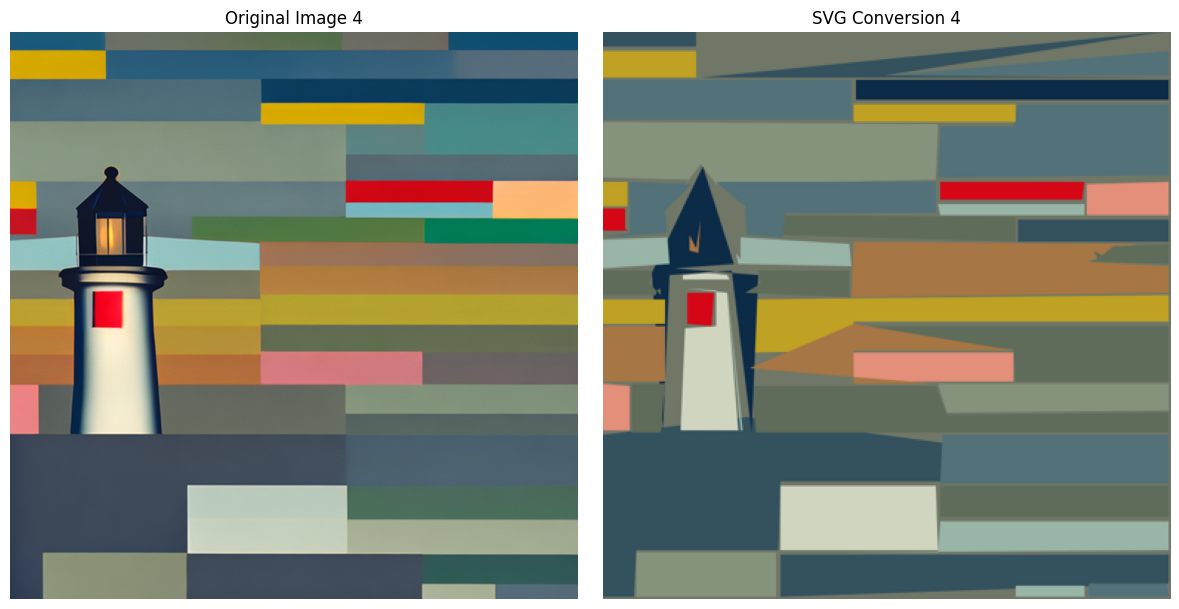

SVG VQA Score: 0.3683
SVG Aesthetic Score: 0.4753
SVG Competition Score: 0.4492
❌ Not better than current best: 0.6587
Image generation time: 7.50s
SVG conversion time: 0.66s
Image evaluation time: 3.36s
Total time for attempt 4: 12.17s

=== Attempt 5/5 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Converting to SVG... SVG size: 3181 bytes


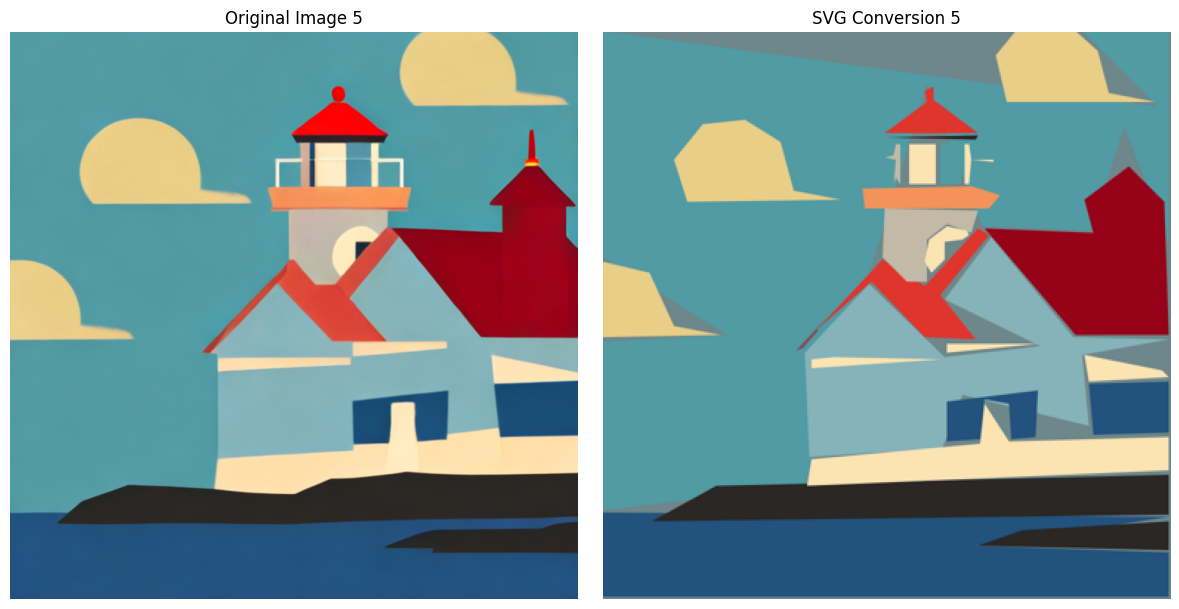

SVG VQA Score: 0.4621
SVG Aesthetic Score: 0.5845
SVG Competition Score: 0.5551
❌ Not better than current best: 0.6587
Image generation time: 7.23s
SVG conversion time: 1.04s
Image evaluation time: 3.39s
Total time for attempt 5: 12.19s

=== Timing Summary ===
Average image generation time: 7.36s
Average SVG conversion time: 0.85s
Average image evaluation time: 31.31s
Average time per attempt: 34.90s
Total processing time (5 attempts): 174.50s
Best score achieved: 0.6587


In [10]:
## Note: These parameters are just for testing - modify parameters in the model definition for submission

prompt = ("Close up of "
          "a lighthouse overlooking the ocean"
          " flat color blocks, beautiful, minimal details, solid colors only")

negative_prompt = "lines, hatching, textures, patterns, details, outlines"

best_svg, best_score = generate_and_convert(prompt, negative_prompt=negative_prompt, num_inference_steps=20, num_attempts=5)

# Our Model Function
## Configure parameters for submission here!

In [11]:
#| export

class Model:
    def __init__(self):
        '''Optional constructor, performs any setup logic, model instantiation, etc.'''
        
        # Set number of image attempts per prompt for competition here...

        self.num_attempts_per_prompt = 0 + len(DEFAULT_SVGS)
        self.num_inference_steps = 15
        self.guidance_scale = 15

        self.prompt_prefix = "Close up of"
        self.prompt_suffix = "flat color blocks, beautiful, minimal details, solid colors only"
        self.negative_prompt = "lines, hatching, textures, patterns, details, outlines"

        self.last_score = None
            
        pass
      
    def predict(self, prompt: str) -> str:
        '''Generates SVG which produces an image described by the prompt.

        Args:
            prompt (str): A prompt describing an image
        Returns:
            String of valid SVG code.
        '''

        full_prompt = self.prompt_prefix + " " + prompt + " " + self.prompt_suffix

        best_svg, best_score = generate_and_convert(
            full_prompt,
            negative_prompt=self.negative_prompt,
            num_attempts=self.num_attempts_per_prompt,
            num_inference_steps=self.num_inference_steps,
            guidance_scale=self.guidance_scale,
            verbose=False
        )

        self.last_score = best_score
        
        return best_svg

# Test Model (LB prediction!)
* Try running the model against the train data
* Uses the scoring metric to make an LB prediction
* Note run-time (should give good idea if things are fast enough to submit)

In [12]:
# # Read the CSV file
# df = pd.read_csv('/kaggle/input/drawing-with-llms/train.csv')

# # uncomment to test on just a few
# #df = df.head(3)

# # Initialize the model
# model = Model()

# # Create arrays to store scores and timing data
# scores = []
# generation_times = []

# for i, row in enumerate(df.iterrows()):
#     description = row[1]['description']
    
#     # Start timing
#     start_time = time.time()
    
#     # Generate image from description
#     svg = model.predict(description)
#     rendered_img = svg_to_png(svg)
    
#     # End timing
#     end_time = time.time()
#     generation_time = end_time - start_time
#     generation_times.append(generation_time)
    
#     # Get the score
#     score = model.last_score
#     scores.append(score)
        
#     # Display the image being processed
#     plt.figure(figsize=(10, 8))
#     plt.imshow(rendered_img)
#     plt.title(f"Prompt: {description}\nScore: {score:.2f}")
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()
    
#     # Print progress, current average score, and timing info
#     current_avg_score = np.mean(scores)
#     current_avg_time = np.mean(generation_times)
    
#     print(f"Processed {i+1}/{len(df)} images")
#     print(f"Current average score: {current_avg_score:.2f}")
#     print(f"Time for this image: {generation_time:.2f}s")
#     print(f"Current average generation time: {current_avg_time:.2f}s")
    
# # When all done, calculate final statistics
# avg_score = np.mean(scores)
# avg_generation_time = np.mean(generation_times)
# total_time_taken = sum(generation_times)

# # Calculate projections for 500 images
# projected_time_500_images = 500 * avg_generation_time
# projected_hours = projected_time_500_images / 3600

# print("\n=== SUMMARY ===")
# print(f"Images processed: {len(df)}")
# print(f"Final average score: {avg_score:.2f}")
# print(f"Average generation time per image: {avg_generation_time:.2f} seconds")
# print(f"Total time elapsed: {timedelta(seconds=total_time_taken)}")
# print(f"Projected time for 500 images: {projected_hours:.2f} hours ({timedelta(seconds=projected_time_500_images)})")